#Day 3: Optimizing Our CNN
Welcome to Day 3!

On Day 2, we proved that a Convolutional Neural Network (CNN) is far superior to a Multi-Layer Perceptron (MLP) for image tasks. Our basic CNN successfully classified fresh vs. rotten fruit with high accuracy (~97%).

However, we saw a small gap between our training and validation accuracy, which means our model was still overfitting a little.

Today's Goal: Our goal is to reduce overfitting and improve model stability. We will use the techniques we've learned to build a final, robust, and highly-performant model.

Load our datasets.

Review the theory of Regularization (L2, Batch Norm, Dropout).

Build a new, pro-level CNN that uses these techniques effectively.

Train and Compare this new model to our previous attempts.

##Cell 1: Setup - Importing Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import math
from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(f"TensorFlow Version: {tf.__version__}")
print("All libraries imported.")

TensorFlow Version: 2.19.0
All libraries imported.


##Cell 2: Define Dataset Parameters
We must use the exact same parameters for a fair comparison.

In [3]:
# We will resize all images to 64x64
IMG_SIZE = 64
print(f"Image size set to: {IMG_SIZE}x{IMG_SIZE} pixels")

# We will train in batches of 32 images at a time
BATCH_SIZE = 32
print(f"Batch size set to: {BATCH_SIZE}")

# Our images have 3 color channels (R, G, B)
CHANNELS = 3
print(f"Number of color channels: {CHANNELS}")

# Our dataset has 6 classes
NUM_CLASSES = 6
print(f"Number of classes: {NUM_CLASSES}")

Image size set to: 64x64 pixels
Batch size set to: 32
Number of color channels: 3
Number of classes: 6


##Cell 3: Define File Paths

In [2]:
# =============================================
# Execute this code only when you Dont have dataset || prefer when you are executing this in Google colab
# ==============================================
# Download the dataset from Kaggle using kagglehub

import os
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sriramr/fruits-fresh-and-rotten-for-classification")

print("Path to dataset files:", path)

# The downloaded dataset structure is typically dataset/train and dataset/test
# Adjust the base_dir to point to the extracted dataset folder
base_dir = os.path.join(path, "dataset")

print(f"Base directory: {base_dir}")
print("Exists:", os.path.exists(base_dir))


# Training data path
train_dir = os.path.join(base_dir, "train")
print(f"Training data path: {train_dir}")
print("Exists:", os.path.exists(train_dir))

# Test data path
test_dir = os.path.join(base_dir, "test")
print(f"Test data path: {test_dir}")
print("Exists:", os.path.exists(test_dir))

100%|██████████| 3.58G/3.58G [00:30<00:00, 127MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sriramr/fruits-fresh-and-rotten-for-classification/versions/1
Base directory: /root/.cache/kagglehub/datasets/sriramr/fruits-fresh-and-rotten-for-classification/versions/1/dataset
Exists: True
Training data path: /root/.cache/kagglehub/datasets/sriramr/fruits-fresh-and-rotten-for-classification/versions/1/dataset/train
Exists: True
Test data path: /root/.cache/kagglehub/datasets/sriramr/fruits-fresh-and-rotten-for-classification/versions/1/dataset/test
Exists: True


##Cell 4: Load and Prepare Datasets

In [4]:
# Load Training Data
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)
print("Loaded Training Data.")

# Load Validation/Test Data
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)
print("Loaded Validation (Test) Data.")

# Get Class Names
class_names = train_dataset.class_names
print(f"Class names: {class_names}")

# Configure for Performance
AUTOTUNE = tf.data.AUTOTUNE
# We add .repeat() to make sure the dataset loops for each epoch
train_ds = train_dataset.cache().repeat().prefetch(buffer_size=AUTOTUNE)
val_ds = validation_dataset.cache().repeat().prefetch(buffer_size=AUTOTUNE)
print("Applied .cache(), .repeat(), and .prefetch() to both datasets.")

Found 10901 files belonging to 6 classes.
Loaded Training Data.
Found 2698 files belonging to 6 classes.
Loaded Validation (Test) Data.
Class names: ['freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges']
Applied .cache(), .repeat(), and .prefetch() to both datasets.


In [5]:
# Calculate steps_per_epoch for training
# We take the total number of training images and divide by the batch size
# (We know these numbers from the output of the cell above)
steps_per_epoch = math.ceil(10901 / BATCH_SIZE)

# Calculate validation_steps for testing
validation_steps = math.ceil(2698 / BATCH_SIZE)

print(f"Total training steps per epoch: {steps_per_epoch}")
print(f"Total validation steps per epoch: {validation_steps}")

Total training steps per epoch: 341
Total validation steps per epoch: 85


Cell 5: What is "Regularization"? (Theory)
Regularization is any technique used to prevent overfitting.

Overfitting is when a model "memorizes" the training data instead of "learning" the general patterns.

Today, we will build a model that uses three key techniques:

L2 Regularization (kernel_regularizer):

The Problem: An overfitting model often relies too much on a few specific weights, causing those weights to become very large.

The Fix: We add a "penalty" to the loss function based on the squared value of the weights. This forces the model to keep all weights small.

Batch Normalization (BatchNormalization):

The Problem: As data flows through the network, the outputs of one layer can become very large or small, making it hard for the next layer to learn.

The Fix: This layer "re-normalizes" the output of the previous layer at every batch. This stabilizes and speeds up training and also acts as a mild regularizer.

Dropout (Dropout):

The Problem: Neurons can "co-adapt," meaning they learn to depend on each other. This is a form of memorization.

The Fix: This layer randomly "drops out" (turns off) a fraction of neurons (e.g., 50%) during each training step. This forces each neuron to become more robust and learn useful features on its own.

##Cell 6: Build the "Pro" CNN (Model 3)
We will now build a robust, modern CNN.

Our New Strategy:

We will not use L2 regularization and BatchNormalization together, as we saw this can make the model unstable. We'll let BatchNormalization handle the convolutional blocks.

We will use GlobalAveragePooling2D instead of Flatten. This is a very powerful regularizer that dramatically reduces parameters.

We will use a single, strong Dropout layer before the final output.

In [6]:
from tensorflow.keras import layers

# --- Build the "Pro" CNN (Functional API) ---

# 1. Define the input shape
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='input_image')

# 2. Rescale
x = layers.Rescaling(1./255, name='rescaling')(inputs)

# --- 3. First Conv Block ---
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_1a')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_1b')(x)
x = layers.BatchNormalization(name='batchnorm_1')(x)
x = layers.MaxPooling2D((2, 2), name='maxpool_1')(x)

# --- 4. Second Conv Block ---
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_2a')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_2b')(x)
x = layers.BatchNormalization(name='batchnorm_2')(x)
x = layers.MaxPooling2D((2, 2), name='maxpool_2')(x)

# --- 5. Third Conv Block ---
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_3a')(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_3b')(x)
x = layers.BatchNormalization(name='batchnorm_3')(x)
x = layers.MaxPooling2D((2, 2), name='maxpool_3')(x)

# --- 6. The "Pro" Move: Global Average Pooling ---
# This replaces Flatten and the first Dense layer.
# It takes the 128 (8x8) feature maps and outputs just 128 average values.
x = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)

# --- 7. Final Head ---
x = layers.Dense(128, activation='relu', name='dense_1')(x)
x = layers.Dropout(0.4, name='dropout_final')(x) # A single, strong Dropout
outputs = layers.Dense(NUM_CLASSES, activation='softmax', name='output_layer')(x)

# Create the model
model_pro_cnn = keras.Model(inputs=inputs, outputs=outputs)

print("Pro CNN model built successfully.")
model_pro_cnn.summary()

Pro CNN model built successfully.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1a (Conv2D)                │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1b (Conv2D)                │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_1                     │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_1 (MaxPooling2D)        │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2a (Conv2D)                │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2b (Conv2D)                │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_2                     │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_2 (MaxPooling2D)        │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3a (Conv2D)                │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3b (Conv2D)                │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_3                     │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_3 (MaxPooling2D)        │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_final (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 305,190 (1.16 MB)

 Trainable params: 304,742 (1.16 MB)

 Non-trainable params: 448 (1.75 KB)

##Cell 7: Compile the "Pro" CNN

In [7]:
model_pro_cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Pro CNN model compiled.")

Pro CNN model compiled.


##Cell 8: Train the "Pro" CNN
###Let's train this new model. This architecture is designed to be stable and resist overfitting, so we should see smooth, consistent improvement.

In [8]:
print("Starting Pro CNN model training for 30 epochs...")
# We save the history to plot it later
history_pro_cnn = model_pro_cnn.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    verbose=1 # Show progress
)

print("\nPro CNN training complete.")

Starting Pro CNN model training for 30 epochs...
Epoch 1/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 50s 116ms/step - accuracy: 0.7529 - loss: 0.7110 - val_accuracy: 0.4266 - val_loss: 2.5318
Epoch 2/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.9016 - loss: 0.2883 - val_accuracy: 0.7887 - val_loss: 0.7390
Epoch 3/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9238 - loss: 0.2138 - val_accuracy: 0.8314 - val_loss: 0.4659
Epoch 4/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9466 - loss: 0.1486 - val_accuracy: 0.5686 - val_loss: 1.8897
Epoch 5/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9531 - loss: 0.1315 - val_accuracy: 0.7780 - val_loss: 0.7070
Epoch 6/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9627 - loss: 0.1092 - val_accuracy: 0.7372 - val_loss: 1.4296
Epoch 7/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9650 - loss: 0.1024 - val_accuracy: 0.9744 - val_loss: 0.0752
Epoch 8/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 5s 15

##Cell 9: Visualize "Pro" CNN Training History
This is the moment of truth. Let's plot the loss and accuracy. We are looking for two things:

High Accuracy: The val_accuracy (orange) should be high (hopefully > 97%).

No Overfitting: The loss (blue) and val_loss (orange) lines should be very close together.

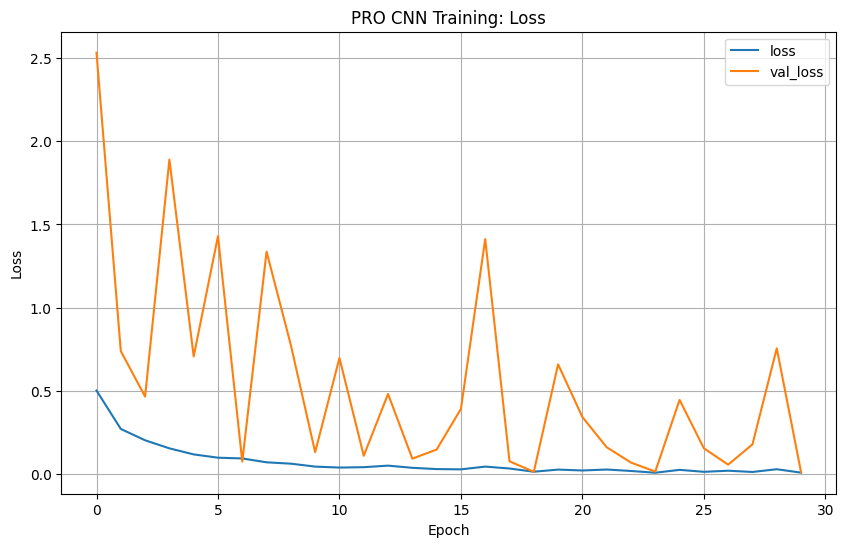

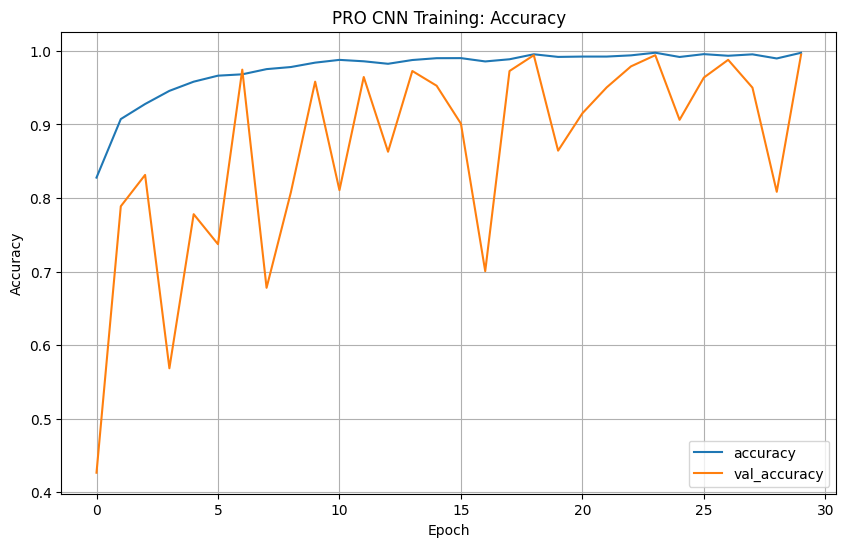

The best validation accuracy our PRO CNN achieved was: 99.48%


In [9]:
# Convert the new history to a DataFrame
history_pro_df = pd.DataFrame(history_pro_cnn.history)

# Plot Loss
history_pro_df[['loss', 'val_loss']].plot(figsize=(10, 6))
plt.title("PRO CNN Training: Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Plot Accuracy
history_pro_df[['accuracy', 'val_accuracy']].plot(figsize=(10, 6))
plt.title("PRO CNN Training: Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

# Get the final, best validation accuracy
final_pro_acc = max(history_pro_cnn.history['val_accuracy'])
print(f"The best validation accuracy our PRO CNN achieved was: {final_pro_acc * 100:.2f}%")

##Cell 10: Final Model Comparison (Day 1 vs. Day 2 vs. Day 3)
Now let's compare all the models we've built. We'll load our models from Day 2 (model_mlp.keras and model_cnn.keras) and compare them against our new "Pro" model.

In [10]:
# --- Load the saved models from Day 2 ---
# (Make sure the .keras files are in the same directory)

try:
    model_mlp = keras.models.load_model('day2_mlp_model.keras')
    print("Successfully loaded 'day2_mlp_model.keras'")
except Exception as e:
    print(f"Could not load 'day2_mlp_model.keras'. Error: {e}")
    model_mlp = None

try:
    model_cnn = keras.models.load_model('day2_cnn_model.keras')
    print("Successfully loaded 'day2_cnn_model.keras'")
except Exception as e:
    print(f"Could not load 'day2_cnn_model.keras'. Error: {e}")
    model_cnn = None

Could not load 'day2_mlp_model.keras'. Error: File not found: filepath=day2_mlp_model.keras. Please ensure the file is an accessible `.keras` zip file.
Could not load 'day2_cnn_model.keras'. Error: File not found: filepath=day2_cnn_model.keras. Please ensure the file is an accessible `.keras` zip file.


###Architecture Comparison
Let's look at the summaries to see how different their structures and parameter counts are.

In [11]:
if model_mlp:
    print("--- 1. Day 2 MLP Model ---")
    model_mlp.summary()

if model_cnn:
    print("\n\n--- 2. Day 2 Basic CNN Model ---")
    model_cnn.summary()

print("\n\n--- 3. Day 3 'Pro' CNN Model ---")
model_pro_cnn.summary()



--- 3. Day 3 'Pro' CNN Model ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1a (Conv2D)                │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1b (Conv2D)                │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_1                     │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_1 (MaxPooling2D)        │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2a (Conv2D)                │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2b (Conv2D)                │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_2                     │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_2 (MaxPooling2D)        │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3a (Conv2D)                │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3b (Conv2D)                │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_3                     │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_3 (MaxPooling2D)        │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_final (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 914,676 (3.49 MB)

 Trainable params: 304,742 (1.16 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 609,486 (2.33 MB)